# Group 38 : Comparative study between different investment strategies

Suyash Kumar, Shikha Tomar, Manideep Gongalla


In [1]:
import sqlite3
import os
from sqlite3 import Error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

#Intializing the SQLite connection and creating some common functions that are used by multiple functions later on
def create_connection(db_file, delete_db=False):
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(create_table_sql, drop_table_name=None):
    if drop_table_name:  
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)

    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)


def execute_sql_statement(sql_statement):
    cur.execute(sql_statement)
    rows = cur.fetchall()

    return rows

conn = create_connection("stockMarket.db", delete_db=False)
cur = conn.cursor()

In [2]:
#
def initialize_database():
    # table to store general info on indexes
    sql_statement = """
            CREATE TABLE Indexes 
                (Index_ID INTEGER PRIMARY KEY AUTOINCREMENT,
                 Index_Symbol TEXT NOT NULL,
                 Index_Name TEXT NOT NULL 
                );"""
    create_table(sql_statement, 'Indexes')
    # table to store price data for indexes
    sql_statement = """
            CREATE TABLE Index_Price 
                (Index_ID INTEGER, 
                 Date TEXT,
                 Open REAL,
                 High REAL,
                 Low REAL,
                 Close REAL,
                 Volume REAL,
                 FOREIGN KEY(Index_ID) REFERENCES Indexes(Index_ID)             
                );"""
    create_table(sql_statement, 'Index_Price')
    # creating table for general info on the stocks
    sql_statement = """
            CREATE TABLE Stocks 
                (Stock_ID INTEGER PRIMARY KEY AUTOINCREMENT,
                 Stock_Symbol TEXT NOT NULL,
                 Stock_Name TEXT NOT NULL,
                 Sector TEXT NOT NULL,
                 UNIQUE(Stock_Symbol)
                );"""
    create_table(sql_statement, 'Stocks')
    # creating table for general info on the stocks
    sql_statement = """
            CREATE TABLE Stock_Index 
                (Stock_ID INTEGER NOT NULL,
                 Index_ID INTEGER NOT NULL,
                 Weight INTEGER NOT NULL,
                 FOREIGN KEY(Index_ID) REFERENCES Indexes(Index_ID),
                 FOREIGN KEY(Stock_ID) REFERENCES Stocks(Stock_ID) 
                );"""
    create_table(sql_statement, 'Stock_Index')
    # creating table for the prices of all the stocks
    sql_statement = """
            CREATE TABLE Stock_Price 
                (Stock_ID INTEGER, 
                 Date REAL,
                 Open REAL,
                 High REAL,
                 Low REAL,
                 Close REAL,
                 Volume REAL,
                 FOREIGN KEY(Stock_ID) REFERENCES Stocks(Stock_ID)          
                );"""
    create_table(sql_statement, 'Stock_Price')

In [3]:
# inserting index and stocks data in the table
def insert_index_info():
    index_data = [('IXIC', 'Nasdaq Composite'), ('DJIA', 'Dow Jones Industrial Average'),
                  ('NDX', 'Nasdaq 100'), ('RUT', 'Russell 2000'), ('SPX', 'S&P 500')]
    cur.executemany(f"INSERT INTO Indexes(Index_Symbol, Index_Name) VALUES(?,?);", index_data)
    conn.commit()

# inserting index prices and stocks prices in the table
def insert_data(tablename, tableCol, df):
    values_count = ','.join(['?'] * len(tableCol))
    data_list = df.values.tolist()
    data_splitted = np.array_split(data_list, 3) #SQLite does not support bulk insertion of more than 1000 rows
    for data in data_splitted:
        cur.executemany(f"INSERT OR IGNORE INTO {tablename}{tableCol} VALUES ({values_count});", data)
        conn.commit()
    del df

def get_data_from_table(col_name, compare_col, compare_data, table_name):
    row = execute_sql_statement(f"select {col_name} from {table_name} where {compare_col} in {tuple(compare_data)}")
    return row

def get_dataframe_index(filename):
    file_type = filename.split('.')[1]
    if file_type == 'csv':
        df = pd.read_csv(filename)
        index_ID = filename.split('_')[1][:-4]
    else:
        df = pd.read_excel(filename)
        index_ID = filename.split('_')[1][:-5]
    return df, index_ID

def get_dataframe_stock(filename):
    df = pd.read_csv(filename)
    index_ID = filename.split('/')[2][:-4]
    return df, index_ID

def insert_stock_info():
    table_col_stock = ('Stock_Symbol', 'Stock_Name', 'Sector')
    table_col_stock_index = ('Stock_ID', 'Index_ID', 'Weight')
    datasets = ['datasets/Holdings_DJIA.xlsx', 'datasets/Holdings_NDX.csv', 'datasets/Holdings_RUT.csv',
                'datasets/Holdings_SPX.xlsx','datasets/Holdings_IXIC.xlsx']
    for filename in datasets:
        df, index_symbol = get_dataframe_index(filename)
        index_symbol = index_symbol.split()
        index_symbol.append('')
        df.rename(columns={"Ticker": "Stock_Symbol", "Name": "Stock_Name"}, inplace=True)
        df_stock = df[list(table_col_stock)]
        insert_data('Stocks', table_col_stock, df_stock)

        row = get_data_from_table('Index_ID', 'Index_Symbol', index_symbol, 'Indexes')
        df['Index_ID'] = row[0][0]
        stock_symbol = df['Stock_Symbol'].tolist()
        row = get_data_from_table('Stock_ID', 'Stock_Symbol', stock_symbol, 'Stocks')
        df['Stock_ID'] = pd.DataFrame(row)
        df_stock_index = df[['Stock_ID', 'Index_ID', 'Weight']]
        insert_data('Stock_Index', table_col_stock_index, df_stock_index)

def insert_index_price_data():
    table_col = ('Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Index_ID')
    table_name = 'Index_Price'
    datasets = ['datasets/HistoricalData_SPX.csv', 'datasets/HistoricalData_IXIC.csv', 'datasets/HistoricalData_DJIA.csv',
                'datasets/HistoricalData_NDX.csv', 'datasets/HistoricalData_RUT.csv']
    for filename in datasets:
        df, index_symbol = get_dataframe_index(filename)
        index_symbol = index_symbol.split()
        index_symbol.append('')
        row = get_data_from_table('Index_ID', 'Index_Symbol', index_symbol, 'Indexes')
        df['Index_ID'] = row[0][0]
        insert_data(table_name, table_col, df)

def insert_stock_price_data():
    table_col = ('Stock_ID', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume')
    table_name = 'Stock_Price'
    dir = 'datasets/Stocks/'
    datasets = [file for file in os.listdir(os.getcwd()+'\datasets\Stocks')]
    for filename in datasets:
        df, stock_symbol = get_dataframe_stock(dir + filename)
        stock_symbol = stock_symbol.split()
        stock_symbol.append('')
        row = get_data_from_table('Stock_ID', 'Stock_Symbol', stock_symbol, 'Stocks')
        if len(row) > 0:
            df['Stock_ID'] = pd.DataFrame(row*df.size)
            df_stock_price = df[list(table_col)]
            insert_data(table_name, table_col, df_stock_price)

In [ ]:
############ NOTE: SINCE THE DATASET IS QUITE HUGE, IT TAKES A WHILE TO CREATE THE DB ###########
#only call once while creating the db and tables
initialize_database()
#Inserting Index and Stock data on Initializing
insert_index_info()
insert_stock_info()
#Inserting Index data only on Initializing
insert_index_price_data()
#Insterting Stock Data only on Initializing
insert_stock_price_data()

In [4]:
sql: str = f"SELECT Index_Symbol, Index_Name FROM Indexes"
indexes_data = pd.read_sql_query(sql, conn)
print(indexes_data, end='\n\n')
infinte_loop = True
while infinte_loop:
    index_symbol = input("Select your preferred index for stock selection: ")
    print('\n')
    sql: str = f"SELECT Stock_Symbol, Stock_Name FROM Stocks s JOIN Stock_Index si ON s.Stock_ID = si.Stock_ID JOIN Indexes i on si.Index_ID = i.Index_ID WHERE i.Index_Symbol = '{index_symbol}' ORDER BY si.Weight DESC LIMIT 10;"
    stock_list = pd.read_sql_query(sql, conn)
    if stock_list.size > 0:
        print(stock_list, end='\n\n')
        infinte_loop = False
        break

stock_list_bool = input(f"Do you want the complete stock holdings for {index_symbol} ? 'Yes' or 'No': ")
print('\n')
if stock_list_bool == 'Yes':   
    sql: str = f"SELECT Stock_Symbol, Stock_Name FROM Stocks s JOIN Stock_Index si ON s.Stock_ID = si.Stock_ID JOIN Indexes i on si.Index_ID = i.Index_ID WHERE i.Index_Symbol = '{index_symbol}' ORDER BY si.Weight DESC;"
    stock_list = pd.read_sql_query(sql, conn)
    print(stock_list, end='\n\n')

stock, capital, stop_loss = '', '', ''
while not stock or not capital or not stop_loss:
    stock = input("Enter the stock symbol from the above list: ")
    capital = float(input("Enter your desired Capital: "))
    stop_loss = float(input("Enter your risk apetite/Stop Loss %: ")) #Percentage of capital loss to exit the trade

sql: str = f"SELECT DATE, CLOSE FROM Stock_Price sp JOIN Stocks s ON sp.Stock_ID = s.Stock_ID WHERE s.Stock_Symbol = '{stock}'"
stock_data = pd.read_sql_query(sql, conn)

  Index_Symbol                    Index_Name
0         IXIC              Nasdaq Composite
1         DJIA  Dow Jones Industrial Average
2          NDX                    Nasdaq 100
3          RUT                  Russell 2000
4          SPX                       S&P 500

Select your preferred index for stock selection: DJIA


  Stock_Symbol                Stock_Name
0         AAPL                Apple Inc.
1         AMGN                Amgen Inc.
2          AXP  American Express Company
3           BA            Boeing Company
4     CASH_USD               U.S. Dollar
5          CAT          Caterpillar Inc.
6          CRM       salesforce.com inc.
7         CSCO        Cisco Systems Inc.
8          CVX       Chevron Corporation
9          DIS       Walt Disney Company

Do you want the complete stock holdings for DJIA ? 'Yes' or 'No': No


Enter the stock symbol from the above list: AAPL
Enter your desired Capital: 100000
Enter your risk apetite/Stop Loss %: 1


In [5]:
# 20 days simple moving average
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data = stock_data.sort_values(by='Date', ascending = True)
stock_data['20_SMA'] = stock_data['Close'].rolling(window=20).mean()
# 50 days simple moving average 
stock_data['50_SMA'] = stock_data['Close'].rolling(window=50).mean()
# 200 days simple moving average 
stock_data['200_SMA'] = stock_data['Close'].rolling(window=200).mean()
std = stock_data['Close'].rolling(20).std()  # Get rolling standard deviation for 20 days
stock_data['bollinger_up'] = stock_data['20_SMA'] + std * 2  # Calculate top band
stock_data['bollinger_down'] = stock_data['20_SMA'] - std * 2  # Calculate bottom band
stock_data['Signal'] = 0.0
stock_data['Signal'] = np.where(stock_data['20_SMA'] > stock_data['50_SMA'], 1.0, 0.0)
stock_data['Position'] = stock_data['Signal'].diff()
stock_data_new = stock_data.set_index('Date')
print(stock_data_new.tail())
stock_data_new = stock_data_new.tail(500) #Selecting the latest 500 rows

                 Close      20_SMA      50_SMA    200_SMA  bollinger_up  \
Date                                                                      
2021-12-05  122.769997  145.172505  143.459603  137.89950    174.303389   
2021-12-07  144.500000  146.102005  143.432602  137.85375    173.795891   
2021-12-08  148.889999  147.179005  143.473802  137.84810    173.440665   
2021-12-10  141.509995  146.961505  143.365602  137.88970    173.340951   
2021-12-11  149.990005  147.320505  143.458002  137.98545    173.657456   

            bollinger_down  Signal  Position  
Date                                          
2021-12-05      116.041621     1.0       0.0  
2021-12-07      118.408119     1.0       0.0  
2021-12-08      120.917345     1.0       0.0  
2021-12-10      120.582059     1.0       0.0  
2021-12-11      120.983554     1.0       0.0  


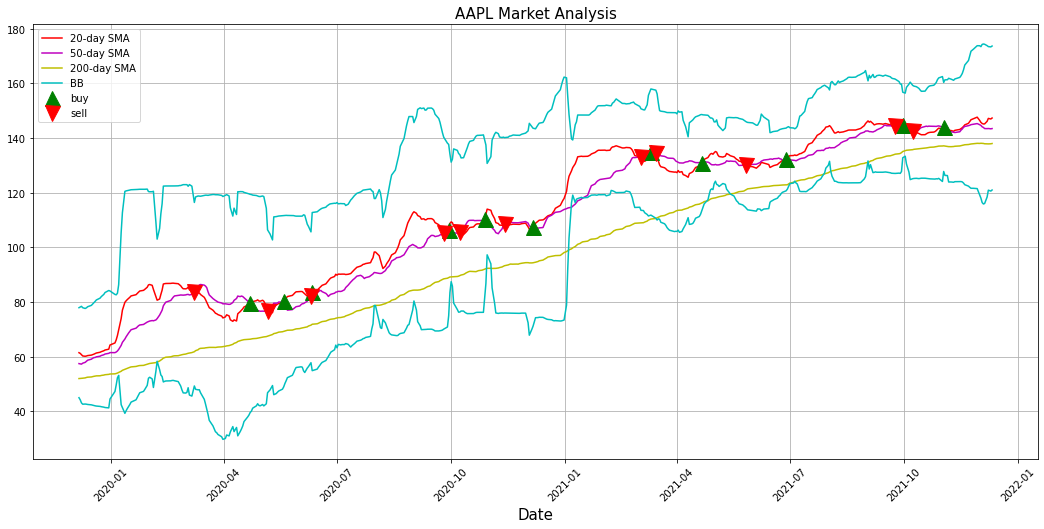

In [6]:
#Plotting 20, 50 & 100 Moving Average and Bollinger Band
plt.rcParams['figure.figsize'] = (18, 8)
plt.plot(stock_data_new.index, stock_data_new['20_SMA'], color='r', label='20-day SMA')
plt.plot(stock_data_new.index, stock_data_new['50_SMA'], color='m', label='50-day SMA')
plt.plot(stock_data_new.index, stock_data_new['200_SMA'], color='y', label='200-day SMA')
plt.plot(stock_data_new.index, stock_data_new['bollinger_up'], color='c', label='BB')
plt.plot(stock_data_new.index, stock_data_new['bollinger_down'], color='c')

plt.plot(stock_data_new[stock_data_new['Position'] == 1].index,
         stock_data_new['20_SMA'][stock_data_new['Position'] == 1], '^', markersize=15, color='g', label='buy')
plt.plot(stock_data_new[stock_data_new['Position'] == -1].index,
         stock_data_new['50_SMA'][stock_data_new['Position'] == -1], 'v', markersize=15, color='r', label='sell')
plt.xlabel('Date', fontsize=15)
plt.title(f'{stock} Market Analysis', fontsize=15)
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [7]:
#Calculating other significant statistical data
shares = float(capital) // float(stock_data['Close'].index[-1])
data = [[stock, index_symbol, shares, stock_data['Close'].skew(), stock_data['Close'].kurt()]]
print(pd.DataFrame(data, columns=["Stock", "Index", "Shares", "Skew", "Kurtosis"]))

  Stock Index  Shares      Skew   Kurtosis
0  AAPL  DJIA     9.0  3.199993  10.943309


In [8]:
stock_data_new['20d-50d'] = stock_data_new['20_SMA'] - stock_data_new['50_SMA']
stock_data_new.tail()
#Regmies are the time duration for which the trade was either profitable or loss-making
# 1 -> profitable regime and 0 -> loss-making regime 
stock_data_new["Regime"] = np.where(stock_data_new['20d-50d'] > 0, 1, 0)
stock_data_new["Regime"] = np.where(stock_data_new['20d-50d'] < 0, -1, stock_data_new["Regime"])
stock_data_new["Signal"] = np.where(stock_data_new['Regime'] < 1, 'Sell', 'Buy')

In [9]:
# To avoid issues with the last row, changing regime to 0 temporarily
idx = stock_data_new.index[-1]
regime_orig = stock_data_new.loc[idx, "Regime"]
stock_data_new.at[idx,"Regime"] = 0
stock_data_new["Signal"] = np.sign(stock_data_new["Regime"] - stock_data_new["Regime"].shift(1))

# Restoring regime data
stock_data_new.at[idx, "Regime"] = regime_orig
stock_data_new.tail(50)


,Close,20_SMA,50_SMA,200_SMA,bollinger_up,bollinger_down,Signal,Position,20d-50d,Regime
Date,,,,,,,,,,
2021-09-28,141.910004,143.405499,144.313200,134.359250,159.747468,127.063530,0.0,0.0,-0.907701,-1
2021-09-29,142.830002,143.746499,144.261800,134.664400,159.719153,127.773846,0.0,0.0,-0.515301,-1
2021-09-30,141.500000,144.766999,144.155800,135.061612,156.756013,132.777986,1.0,1.0,0.611200,1
2021-10-02,135.389999,144.886499,143.892400,135.349300,156.420690,133.352309,0.0,0.0,0.994100,1
2021-10-03,119.980003,144.529000,143.312200,135.525700,158.554634,130.503366,0.0,0.0,1.216800,1
2021-10-05,126.849998,143.616000,142.913800,135.594900,159.707518,127.524481,0.0,0.0,0.702200,1
2021-10-06,126.110001,142.617000,142.536400,135.603450,160.448550,124.785449,0.0,0.0,0.080600,1
2021-10-08,145.600006,142.193500,142.535600,135.735400,159.265914,125.121086,-1.0,-1.0,-0.342100,-1
2021-10-09,148.970001,142.101500,142.597800,135.871350,158.997326,125.205674,0.0,0.0,-0.496300,-1


In [10]:
stock_data_new.loc[stock_data_new['Signal']==1, 'Close']

Date
2020-04-22     69.025002
2020-05-19     78.285004
2020-06-11    118.690002
2020-09-29    114.089996
2020-10-28    111.199997
2020-12-06     84.699997
2021-03-11    151.490005
2021-04-21    133.500000
2021-06-28    134.779999
2021-09-30    141.500000
2021-11-02    135.130005
Name: Close, dtype: float64

In [11]:
# List of all trades with the traded price and its corresponding regime
stock_signals = pd.concat([
        pd.DataFrame({"Price": stock_data_new.loc[stock_data_new["Signal"] == 1, "Close"],
                     "Regime": stock_data_new.loc[stock_data_new["Signal"] == 1, "Regime"],
                     "Signal": "Buy"}),
        pd.DataFrame({"Price": stock_data_new.loc[stock_data_new["Signal"] == -1, "Close"],
                     "Regime": stock_data_new.loc[stock_data_new["Signal"] == -1, "Regime"],
                     "Signal": "Sell"}),
    ])
stock_signals.sort_index(inplace = True)
stock_signals.tail()

,Price,Regime,Signal
Date,,,
2021-09-24,146.919998,-1,Sell
2021-09-30,141.500000,1,Buy
2021-10-08,145.600006,-1,Sell
2021-11-02,135.130005,1,Buy
2021-12-11,149.990005,1,Sell


In [12]:
#Using stock signals to calculate the profitable trades
stock_long_profits = pd.DataFrame({
        "Price": stock_signals.loc[(stock_signals["Signal"] == "Buy") &
                                  stock_signals["Regime"] == 1, "Price"],
        "Profit/Loss": pd.Series(stock_signals["Price"] - stock_signals["Price"].shift(1)).loc[
            stock_signals.loc[(stock_signals["Signal"].shift(1) == "Buy") & (stock_signals["Regime"].shift(1) == 1)].index
        ].tolist(),
        "End Date": stock_signals["Price"].loc[
            stock_signals.loc[(stock_signals["Signal"].shift(1) == "Buy") & (stock_signals["Regime"].shift(1) == 1)].index
        ].index
    })
stock_long_profits

,Price,Profit/Loss,End Date
Date,,,
2020-04-22,69.025002,13.849998,2020-05-06
2020-05-19,78.285004,34.875000,2020-06-10
2020-06-11,118.690002,-6.410004,2020-09-25
2020-09-29,114.089996,-1.362495,2020-10-08
2020-10-28,111.199997,8.060005,2020-11-13
2020-12-06,84.699997,37.360001,2021-03-03
2021-03-11,151.490005,-27.500008,2021-03-15
2021-04-21,133.500000,-8.220001,2021-05-27
2021-06-28,134.779999,12.139999,2021-09-24


In [13]:
# Calculating Stop Loss by using Close
tradeperiods = pd.DataFrame({"Start": stock_long_profits.index,
                            "End": stock_long_profits["End Date"]})
stock_long_profits["Low"] = tradeperiods.apply(lambda x: min(stock_signals.loc[x["Start"]:x["End"], "Price"]), axis = 1)

In [14]:
#Backtesting the stock with the capital and stop loss values provided by the user 
stock_backtest = pd.DataFrame({"Start Portfolio Value": [],
                         "End Portfolio Value": [],
                         "End Date": [],
                         "Shares": [],
                         "Share Price": [],
                         "Trade Value": [],
                         "Profit per Share": [],
                         "Total Profit": [],
                         "Stop-Loss Triggered": []})
port_value = 0.1  # Max proportion of portfolio bet on any trade
batch = 100      # Number of shares bought per batch

for index, row in stock_long_profits.iterrows():
    batches = np.floor(capital * port_value) // np.ceil(batch * row["Price"]) # Maximum number of batches of stocks invested in
    trade_val = batches * batch * row["Price"] # How much money is put on the line with each trade
    if row["Low"] < (1 - stop_loss) * row["Price"]:   # Account for the stop-loss
        share_profit = -np.round((1 - stop_loss) * row["Price"], 2)
        stop_trig = True
    else:
        share_profit = row["Profit/Loss"]
        stop_trig = False
    profit = share_profit * batches * batch # Compute profits
    # Add a row to the backtest data frame containing the results of the trade
    stock_backtest = stock_backtest.append(pd.DataFrame({
                "Start Portfolio Value": capital,
                "End Portfolio Value": capital + profit,
                "End Date": row["End Date"],
                "Shares": batch * batches,
                "Share Price": row["Price"],
                "Trade Value": trade_val,
                "Profit per Share": share_profit,
                "Total Profit": profit,
                "Stop-Loss Triggered": stop_trig
            }, index = [index]))
    capital = max(0, capital + profit)
 
stock_backtest

,Start Portfolio Value,End Portfolio Value,End Date,Shares,Share Price,Trade Value,Profit per Share,Total Profit,Stop-Loss Triggered
2020-04-22,100000.000000,101384.999847,2020-05-06,100.0,69.025002,6902.500153,13.849998,1384.999847,0.0
2020-05-19,101384.999847,104872.499847,2020-06-10,100.0,78.285004,7828.500366,34.875000,3487.500000,0.0
2020-06-11,104872.499847,104872.499847,2020-09-25,0.0,118.690002,0.000000,-6.410004,-0.000000,0.0
2020-09-29,104872.499847,104872.499847,2020-10-08,0.0,114.089996,0.000000,-1.362495,-0.000000,0.0
2020-10-28,104872.499847,104872.499847,2020-11-13,0.0,111.199997,0.000000,8.060005,0.000000,0.0
2020-12-06,104872.499847,108608.499908,2021-03-03,100.0,84.699997,8469.999695,37.360001,3736.000061,0.0
2021-03-11,108608.499908,108608.499908,2021-03-15,0.0,151.490005,0.000000,-27.500008,-0.000000,0.0
2021-04-21,108608.499908,108608.499908,2021-05-27,0.0,133.500000,0.000000,-8.220001,-0.000000,0.0
2021-06-28,108608.499908,108608.499908,2021-09-24,0.0,134.779999,0.000000,12.139999,0.000000,0.0
2021-09-30,108608.499908,108608.499908,2021-10-08,0.0,141.500000,0.000000,4.100006,0.000000,0.0
